In [1]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style("darkgrid")
import lightgbm as lgb

In [2]:
# import grocery data
data_demog = pd.read_csv('hh_demographic.csv')
data_trans = pd.read_csv('transaction_data.csv') # has 2 million rows
data_prods = pd.read_csv('product.csv')

In [3]:
# demographic data
data_demog.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [4]:
# transactional data
data_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [5]:
# product data
data_prods.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [8]:
# strawberries have any 4 different sizes, 9 different manufacturers, 2 deparments and 48 different IDs
data_prods[data_prods.SUB_COMMODITY_DESC == 'STRAWBERRIES'].nunique()

PRODUCT_ID              48
MANUFACTURER             9
DEPARTMENT               2
BRAND                    1
COMMODITY_DESC           2
SUB_COMMODITY_DESC       1
CURR_SIZE_OF_PRODUCT     4
dtype: int64

In [3]:
#data.head(1000).sort_values('DAY')['SALES_VALUE'].rolling(3, min_periods=1).apply(lambda x: mode(x)[0])
def days(day, window):
    days = []
    for i in range(window + 1):
        if day > 0:
            day = day - i
            days.append(day)
    return days

def rolling_mode(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(mode(data_cut.SALES_VALUE)[0][0])
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mode']
    return result

def rolling_mean(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(np.mean(data_cut.SALES_VALUE))
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mean']
    return result

In [5]:
# merge all three datasets
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

In [6]:
# get data for strawberry purchases
data_straw = data.copy()
data_straw = data_straw[data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES']
mode_rolling = rolling_mode(data_straw, window=3)
mean_rolling = rolling_mean(data_straw, window=3)

In [6]:
# try different imputations
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw.merge(mean_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw['price_mean'] = data_straw.groupby('DAY')['SALES_VALUE'].transform(lambda x: x.mean())

In [7]:
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

# restrict dataset to customers who purchased strawberries at least once
b = data.groupby('household_key')['SUB_COMMODITY_DESC'].apply(lambda x: (x == 'STRAWBERRIES').any())
data = data[data.household_key.isin(b[b].index)]
print("Number of shopping trips after removing non-strawberry purchasing customers:", data.BASKET_ID.nunique())

data['BASKET_ID'] = data['BASKET_ID'].astype(str)
data['MANUFACTURER'] = data['MANUFACTURER'].astype(str)

# imputing missing values
data_straw = data.copy()
data_straw = data_straw[(data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES')]
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw[~data_straw.BASKET_ID.duplicated()]
data_straw['purchased'] = 1

# baskets where strawberries were not purchased
data_non_straw = data.copy()
data_non_straw = data_non_straw[data_non_straw.SUB_COMMODITY_DESC != 'STRAWBERRIES']
data_non_straw = data_non_straw[~data_non_straw.BASKET_ID.duplicated()]
data_non_straw = data_non_straw.merge(data_straw[['DAY', 'rolling_mode']], left_on='DAY', right_on='DAY')
data_non_straw['purchased'] = 0

data = pd.concat([data_straw, data_non_straw], axis=0)

# impute product categorical features using mode 
data.loc[data.purchased == 0, 'SALES_VALUE'] = data.loc[data.purchased == 0, 'rolling_mode']
data.loc[data.purchased == 0, 'MANUFACTURER'] = data_straw.loc[:, 'MANUFACTURER'].value_counts().index[0]
data.loc[data.purchased == 0, 'DEPARTMENT'] = data_straw.loc[:, 'DEPARTMENT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COMMODITY_DESC'] = data_straw.loc[:, 'COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'CURR_SIZE_OF_PRODUCT'] = data_straw.loc[:, 'CURR_SIZE_OF_PRODUCT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_DISC'] = data_straw.loc[:, 'COUPON_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_MATCH_DISC'] = data_straw.loc[:, 'COUPON_MATCH_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'SUB_COMMODITY_DESC'] = data_straw.loc[:, 'SUB_COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'BRAND'] = data_straw.loc[:, 'BRAND'].value_counts().index[0]

# drop id columns and rename SALES_VALUE to price
data = data.drop_duplicates()
data.drop(['PRODUCT_ID', 'household_key', 'BASKET_ID'], axis=1, inplace=True)
data.rename(columns={'SALES_VALUE':'price'}, inplace=True)
data.CURR_SIZE_OF_PRODUCT = data.CURR_SIZE_OF_PRODUCT.replace({'16 OZ', '1 LB'})
data = data[data.CURR_SIZE_OF_PRODUCT == '16 OZ']

# balance classed
# data = pd.concat([
#     data[data.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     data[data.purchased == 1]
# ], axis=0)

print(len(data))
data.head()

Number of shopping trips after removing non-strawberry purchasing customers: 108662
109842


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,DAY,price,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,rolling_mode,purchased
0,1646,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,134.0,2.50,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
1,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,125.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
2,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,130.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.00,1
3,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,415.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1
4,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,428.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1


#
Most of the imputed prices are between 1 and 4 dollars, with a few exceptions ranging from 5 to 8 dollars. 

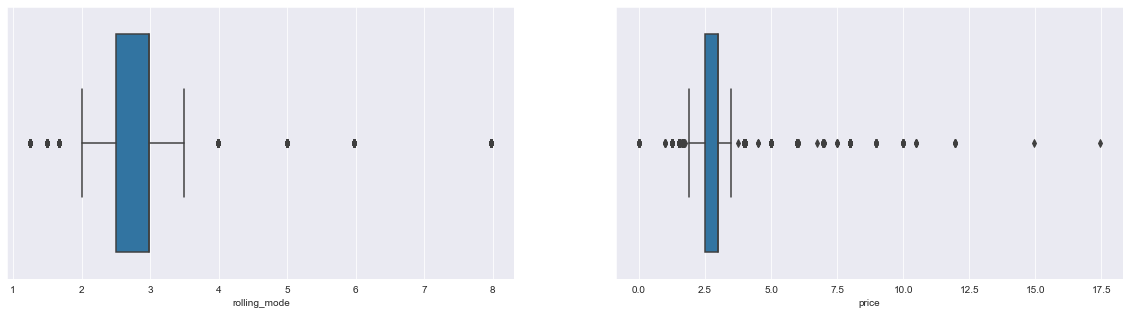

In [221]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x=data.rolling_mode, ax=ax[0])
sns.boxplot(x=data.price, ax=ax[1])

plt.show()

#
Taking the mean price of each day is still to noisy. This can be smoothed by taking the mean or mode of a rolling 3 day period.

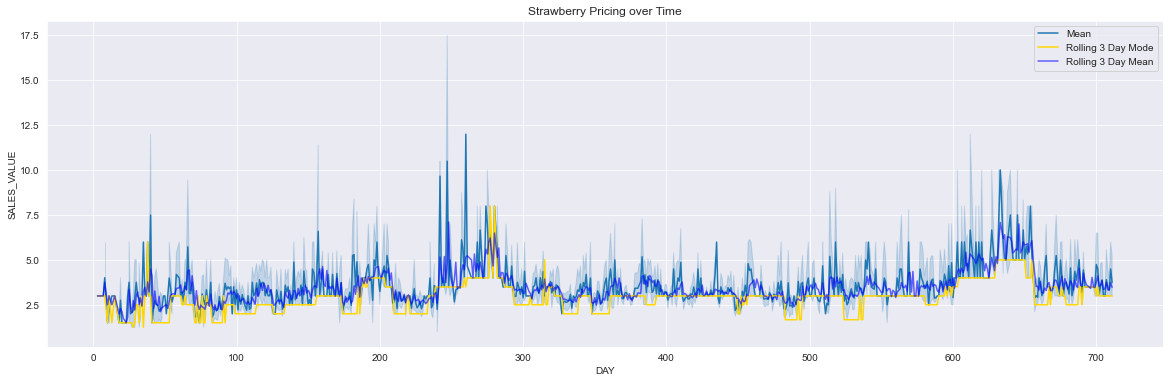

In [38]:
fig, ax = plt.subplots(figsize=(20,6))

sns.lineplot(data=data_straw, x="DAY", y="SALES_VALUE")#, hue="CURR_SIZE_OF_PRODUCT", ax=ax)
sns.lineplot(data=mode_rolling, x="DAY", y="rolling_mode", ax=ax, color='gold')
sns.lineplot(data=mean_rolling, x="DAY", y="rolling_mean", ax=ax, alpha=0.6, color='blue')

plt.legend(['Mean', 'Rolling 3 Day Mode', 'Rolling 3 Day Mean'])

plt.title('Strawberry Pricing over Time')
plt.show()

#
Use SMOTE to balance training data and lightBGM to model demand as a function of price. 

In [8]:
X = data.copy()
X = X.drop(['rolling_mode', 'DAY'], axis=1)

# encode categorical features as integers
from sklearn import preprocessing
categorical_feature = []
for f in X.columns:
    if X[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values))
        X[f] = lbl.transform(list(X[f].values))
        categorical_feature.append(f)

# drop features with low variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X = selector.fit_transform(X)

# wrap in dataframe
X = pd.DataFrame(X)
X.columns = data.drop(['rolling_mode', 'DAY'], axis=1).columns[selector.get_support()]

X_orig = X.copy()

# downsample balance
# X = pd.concat([
#     X[X.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     X[X.purchased == 1]
# ], axis=0)

y = X['purchased']
X = X.drop('purchased', axis=1)

# fix imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X.head()

,MANUFACTURER,DEPARTMENT,COMMODITY_DESC,price,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,0.0,1.0,0.0,2.50,3.0,2.0,0.0,4.0,3.0,0.0,3.0
1,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
2,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
3,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0
4,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0


In [186]:
print(os.getcwd())
pd.concat([X_res, y_res], axis=1).to_csv('cleaned_strawberry_dataset.csv', index=False)

C:\Users\mlentini\OneDrive - Edmund Optics, Inc\Documents\Rowan\Thesis\Notebooks\Dunnhumby Grocery Stores\dunnhumby_The-Complete-Journey\dunnhumby - The Complete Journey CSV


In [9]:
num_round = 50 # number of boosting rounds as used in Biggs
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': '',
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'verbose': 1,
    'max_depth': -1
}

cats = np.where(X.columns.isin([x for x in X.columns if x != 'price']))[0]
model = lgb.LGBMClassifier(n_estimators=num_round, categorical_feature=np.arange(len(X.columns)))#cats#np.where(X.columns.isin(categorical_feature))[0])

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=49)

model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


LGBMClassifier(categorical_feature=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
               n_estimators=50)

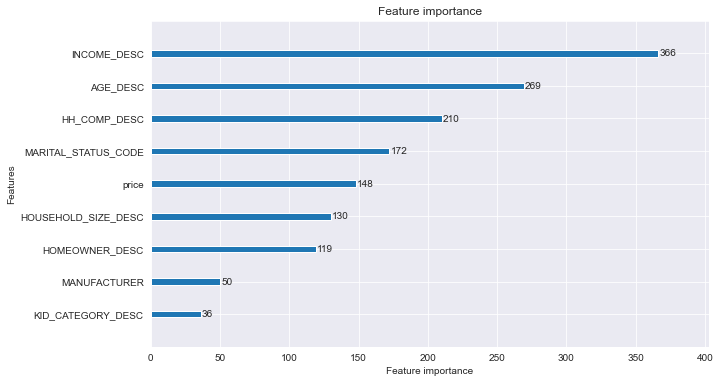

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax=ax)
plt.show()

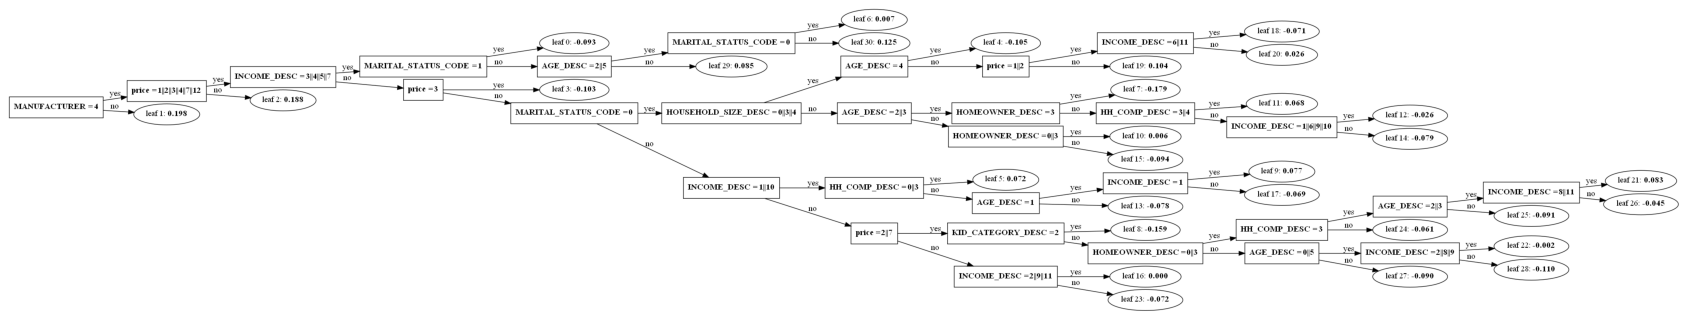

In [11]:
gig, ax = plt.subplots(figsize=(30,8))
lgb.plot_tree(model, ax=ax)
plt.savefig('tree_plot.png')

plt.show()

#
Get counterfactual total expected revenue as a function of price

In [12]:
def counterfactual(X_train, X_test):
    #Biggs et al, 2020 uses 10th and 90th percentile prices in 10% increments
    low_price = X_train.price.quantile(0.05)
    high_price = X_train.price.quantile(0.95)

    print('low price:', low_price)
    print('high price:', high_price)

    prices = np.linspace(low_price, high_price, 11)
    prices = np.linspace(1.99, 4.99, 7)
    revenue = []
    avg_purchase_prob = []
    for price in prices:
        counterfactual = X_test.copy()
        counterfactual.price = price
        purchase_prob = model.predict_proba(counterfactual)[:, 0]
        revenue.append(np.mean(price*purchase_prob))
        avg_purchase_prob.append(np.mean(purchase_prob))

    optimal_price = prices[np.where(revenue == np.max(revenue))][0]
    
    return avg_purchase_prob, revenue, optimal_price, prices

low price: 1.67
high price: 3.99
Optimal price 3.99


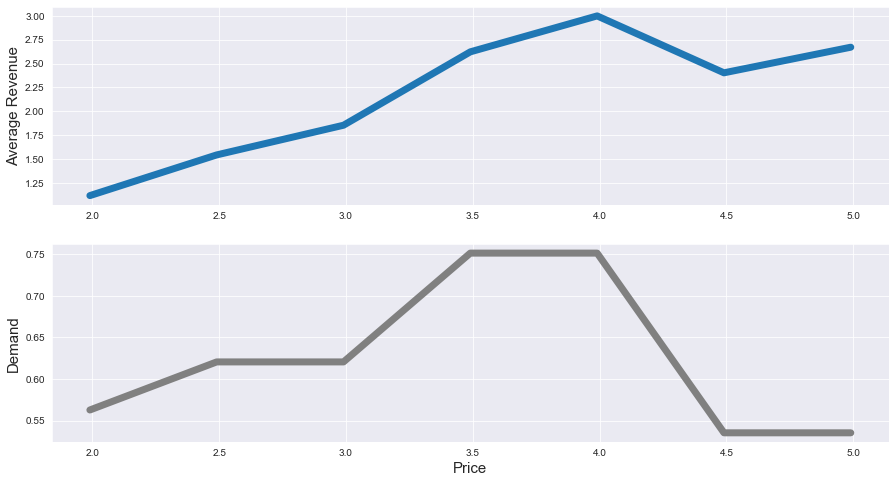

In [13]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=49)
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train_, X_train_)

#avg_purchase_prob = avg_purchase_prob[::-1]
#revenue = prices*avg_purchase_prob

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
plt.show()

In [179]:
# model out-of-sample score
print('In-sample error:', model.score(X_test, y_test))
print('Out-of-sample score:', model.score(X_test, y_test))

In-sample error: 0.7654504898807201
Out-of-sample score: 0.7654504898807201


#
Out-of-sample AUC performed the same as Biggs et al., 2021. We both measured 0.79. Is is unclear whether Biggs et al., balanced the dataset, and if they did which technique was used.

In [14]:
# out-of-sample scores
from sklearn.metrics import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
def evaluate(model, testing_set_x, testing_set_y):
    predictions = model.predict_proba(testing_set_x)
    
    accuracy  = accuracy_score(testing_set_y, predictions[:,1] >= 0.5)
    roc_auc   = roc_auc_score(testing_set_y, predictions[:,1])
    precision = precision_score(testing_set_y, predictions[:,1] >= 0.5)
    recall    = recall_score(testing_set_y, predictions[:,1] >= 0.5)
    pr_auc    = average_precision_score(testing_set_y, predictions[:,1])
    
    result = pd.DataFrame([[accuracy, precision, recall, roc_auc, pr_auc]], columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    return(result)

evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall,ROC_auc,PR_auc
0,0.74015,0.791135,0.652899,0.83111,0.848077


low price: 1.67
high price: 5.0
Optimal price 3.99


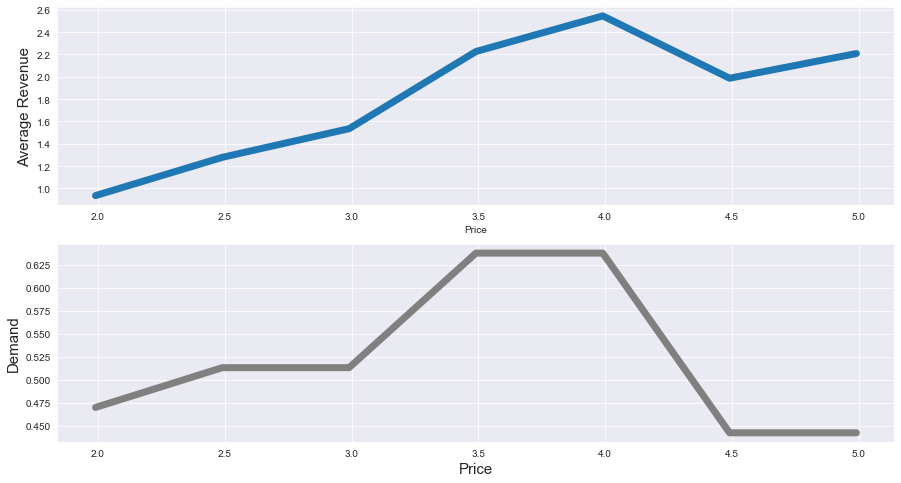

In [15]:
# test on test data
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test)

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('Price')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
plt.show()

#
Experiment with how the demand curve changes for different income buckets

In [38]:
np.concatenate([data.INCOME_DESC.unique().reshape(-1,1), X.INCOME_DESC.unique().astype(int).reshape(-1,1)], axis=1)

array([['100-124K', 0],
       ['75-99K', 10],
       ['Under 15K', 11],
       ['125-149K', 1],
       ['50-74K', 9],
       ['150-174K', 3],
       ['35-49K', 8],
       ['25-34K', 6],
       ['250K+', 7],
       ['200-249K', 5],
       ['15-24K', 2],
       ['175-199K', 4]], dtype=object)

low price: 1.67
high price: 5.0
Optimal price 3.99


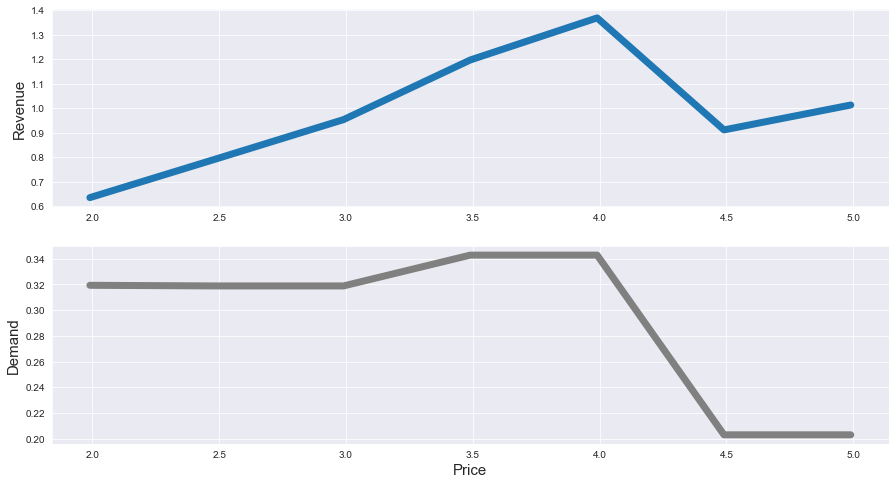

In [43]:
income_bucket = 4
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test[X_test.INCOME_DESC == income_bucket])

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
plt.show()

# 
Plot average revenue by tree depth from SPT

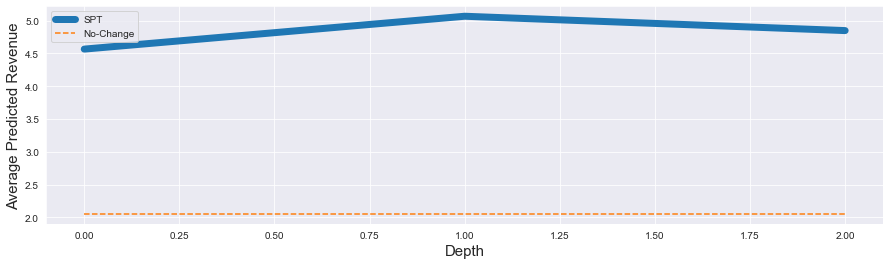

In [171]:
results = [4.566902048915882, 5.067907694500349, 4.849184747578931]
f = 1
results = np.array(results)/f
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,3), results, linewidth=7.0)
ax.plot(np.arange(0,3), np.array(3*[2.0541071833989872])/f, '--')
ax.set_ylabel('Average Predicted Revenue', fontsize=15)
ax.set_xlabel('Depth', fontsize=15)

ax.legend(['SPT', 'No-Change'])
plt.show()